In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('charging_session_count_30.csv', index_col=0, parse_dates=['Period'])
df.head()

,Period,Sessions,Cluster
0,2011-07-29 20:00:00,1,HAMILTON
1,2011-07-29 20:30:00,1,HAMILTON
2,2011-07-29 21:00:00,1,HAMILTON
3,2011-07-29 21:30:00,1,HAMILTON
4,2011-07-29 22:00:00,1,HAMILTON


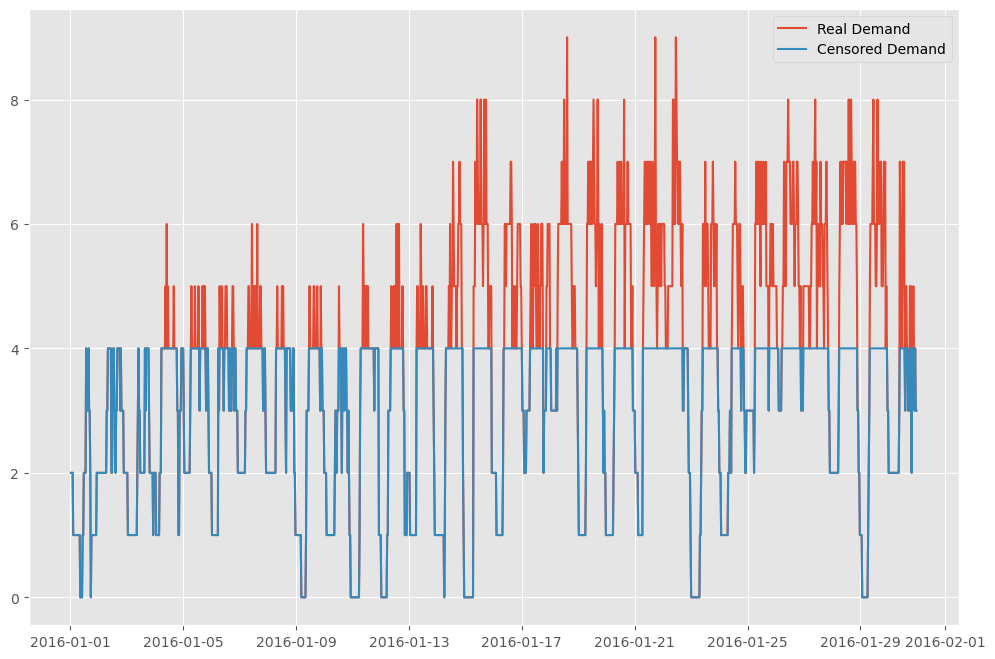

In [2]:

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(12, 8))

df_sample = df[(df.Cluster == 'WEBSTER') & ((df.Period > '2016-01-01') & (df.Period < '2016-01-31'))].copy()
df_sample['Censored'] = df_sample['Sessions'].values

df_sample.loc[df_sample.Sessions > 4, 'Censored'] = 4
df_sample.reset_index(drop=True, inplace=True)
plt.plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand')
plt.plot(df_sample.Period, df_sample.Censored.values, label='Censored Demand')
plt.legend()
plt.show()

In [3]:
import torch.nn as nn
import torch
import numpy as np

In [93]:
class AR_Net(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(AR_Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(hidden_dim, output_dim) 
        # Linear function (readout)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
class AR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AR, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim) 

    def forward(self, x):
        out = self.fc1(x)
        return out

In [94]:
input_dim = 48*7
output_dim = 48
hidden_dim = 100

In [95]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    # Compute loss.
    loss = loss_fn(y_predict, y)

    optimizer.zero_grad()

    loss.backward(retain_graph=True)

    optimizer.step()

    # Calculate MSE and report it
    mse = nn.functional.mse_loss(y_predict, y)

    return mse.data.item()


In [96]:
def poisson_negative_log_likelihood(y_predict, y):
    """ https://en.wikipedia.org/wiki/Poisson_regression#Maximum_likelihood-based_parameter_estimation """
    return -torch.sum(y*y_predict - torch.exp(y_predict))

Epoch: 0 Loss: 1.0704649114608764
Epoch: 1 Loss: 1.02375576877594
Epoch: 2 Loss: 1.0055399131774903
Epoch: 3 Loss: 0.993015337228775
Epoch: 4 Loss: 0.9875008995056153
Epoch: 5 Loss: 0.984520350297292
Epoch: 6 Loss: 0.9819868144989014
Epoch: 7 Loss: 0.9799309026002884
Epoch: 8 Loss: 0.979200078646342
Epoch: 9 Loss: 0.9790735211372376
Epoch: 10 Loss: 0.980952413298867
Epoch: 11 Loss: 0.9849438216686249
Epoch: 12 Loss: 0.9892418828377357
Epoch: 13 Loss: 0.9927394545418876
Epoch: 14 Loss: 0.9913671590805054
Epoch: 15 Loss: 0.9878252111077309
Epoch: 16 Loss: 0.9835050921720617
Epoch: 17 Loss: 0.9792901617156134
Epoch: 18 Loss: 0.9753189380043431
Epoch: 19 Loss: 0.9716986359596251
Epoch: 20 Loss: 0.9683021585827782
Epoch: 21 Loss: 0.9650783053744924
Epoch: 22 Loss: 0.9619713381062384
Epoch: 23 Loss: 0.9589887751340865
Epoch: 24 Loss: 0.9560616907119751
Epoch: 25 Loss: 0.9533369246629568
Epoch: 26 Loss: 0.9508351001033076
Epoch: 27 Loss: 0.9485494304043905
Epoch: 28 Loss: 0.9464590752371426
E

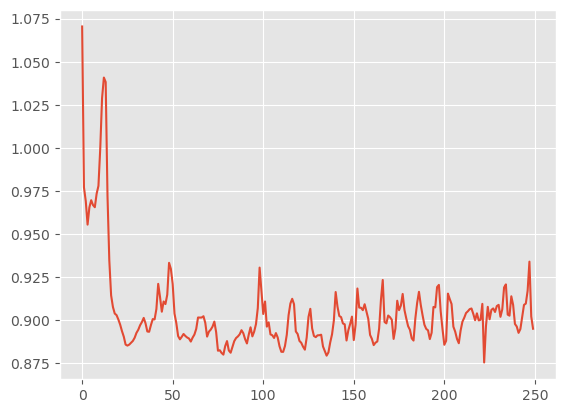

In [104]:
epochs = 250
model = AR_Net(input_dim, output_dim, 256)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = poisson_negative_log_likelihood
losses = []
model.train()
for epoch in range(epochs):
    loss_sum = 0
    for i in range((len(df_sample)-input_dim)//output_dim):
        X_train = torch.tensor(df_sample.iloc[output_dim*i: input_dim + output_dim * i].Sessions.values, dtype=torch.float32).view(1, -1)
        y_train = torch.tensor(df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim].Sessions.values, dtype=torch.float32).view(1, -1)
        loss_sum += train_batch(model, X_train, y_train, optimizer, loss_fn)
    losses.append(loss_sum/epochs)
    print(f'Epoch: {epoch} Loss: {np.mean(losses)}')
plt.plot(losses)

In [105]:
# make prediction
X_eval = df_sample.reset_index(drop=True).iloc[:input_dim]
y_eval = df_sample.reset_index(drop=True).iloc[input_dim:input_dim + output_dim]

model.eval()
y_predict = model.forward(torch.tensor(X_eval.Sessions.values, dtype=torch.float32).view(1, -1))
y_predict = y_predict.detach().numpy().reshape(-1)

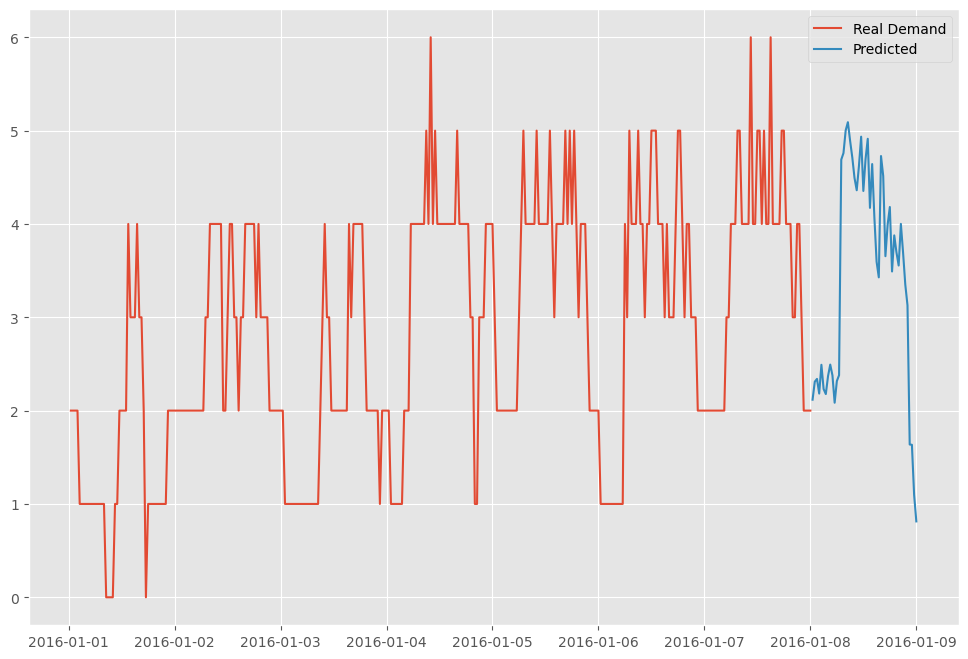

In [106]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(X_eval.Period, X_eval.Sessions.values, label='Real Demand')
ax.plot(y_eval.Period, np.exp(y_predict), label='Predicted')
plt.legend()

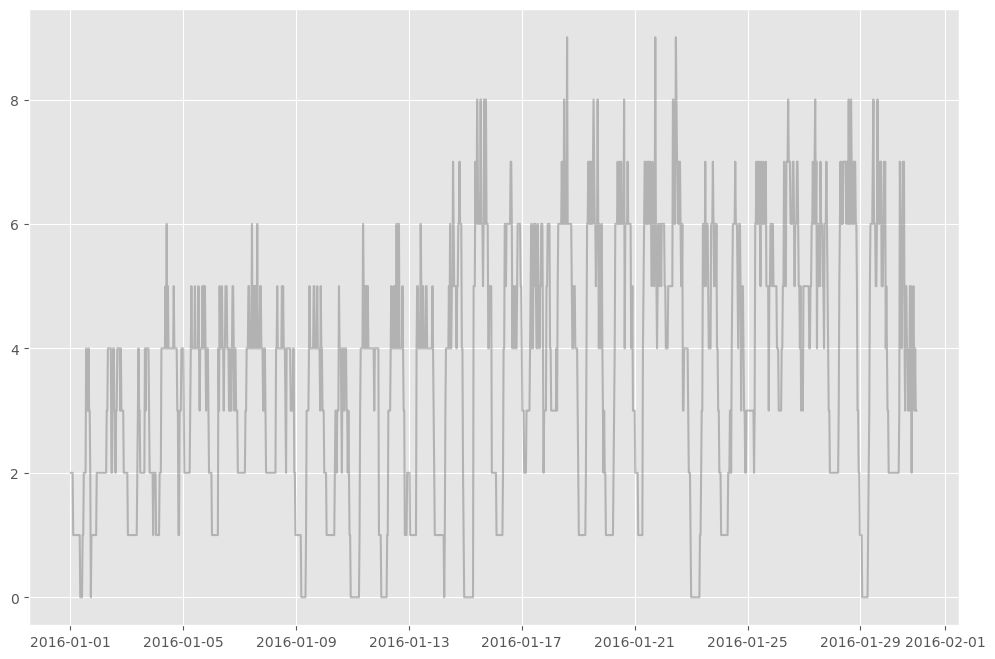

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

KeyboardInterrupt: 

In [107]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_sample.Period, df_sample.Sessions.values, label='Real Demand', color='grey', alpha=0.5)
plt.show()
for i in range((len(df_sample)-input_dim)//output_dim):
   X_train = df_sample.iloc[output_dim*i: input_dim + output_dim * i]
   y_train = df_sample.iloc[output_dim*i + input_dim: output_dim*(1+i) + input_dim]
   line1, = ax.plot(X_train.Period, X_train.Sessions.values, label=f'{i}', color='red', alpha=0.5)
   line2, = ax.plot(y_train.Period, y_train.Sessions.values, label=f'{i}', color='green', alpha=0.5)

   plt.draw()
   plt.pause(1)
   line1.remove()
   line2.remove()